In [2]:
import glob
import numpy as np
import cv2
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import shutil
import os
%matplotlib inline

In [3]:
path='kill_me_baby_datasets'

In [4]:
def get_data2(dpath):
    path_list = glob.glob(dpath+'/*')
    #画像ファイル、ラベルを入れる箱を用意
    x=[]
    y=[]
    name=[]
    #フォルダ名でループを回す
    for label, pic_path in enumerate(path_list):
        #サブフォルダ内のファイルリストを取得
        train_pic_list = glob.glob(pic_path+'/*.png')
        print(pic_path, len(train_pic_list))
        #画像ファイルを取得＋リサイズ、ラベルを用意
        x += [cv2.resize(cv2.imread(i), (128, 128)) for i in train_pic_list]
        y += [label]*len(train_pic_list)
        name += train_pic_list

    #画像をfloat32に変換正規化、ラベルをカテゴリカル化
    x = np.float32(x)/255
    y = keras.utils.to_categorical(y, len(path_list))
    return x, y, name

In [5]:
x_train, y_train, train_name= get_data2(path+'/train')
print(x_train.shape, y_train.shape)

kill_me_baby_datasets/train\agiri 36
kill_me_baby_datasets/train\botsu 8
kill_me_baby_datasets/train\others 52
kill_me_baby_datasets/train\sonya 141
kill_me_baby_datasets/train\yasuna 273
kill_me_baby_datasets/train\yasuna_agiri 4
kill_me_baby_datasets/train\yasuna_sonya 39
kill_me_baby_datasets/train\yasuna_sonya_agiri 1
(554, 128, 128, 3) (554, 8)


In [6]:
x_val, y_val, val_name = get_data2(path+'/val')
print(x_val.shape, y_val.shape)
x_test, y_test, test_name = get_data2(path+'/test')
print(x_test.shape, y_test.shape)

kill_me_baby_datasets/val\agiri 4
kill_me_baby_datasets/val\botsu 1
kill_me_baby_datasets/val\others 6
kill_me_baby_datasets/val\sonya 17
kill_me_baby_datasets/val\yasuna 34
kill_me_baby_datasets/val\yasuna_agiri 0
kill_me_baby_datasets/val\yasuna_sonya 4
kill_me_baby_datasets/val\yasuna_sonya_agiri 0
(66, 128, 128, 3) (66, 8)
kill_me_baby_datasets/test\agiri 4
kill_me_baby_datasets/test\botsu 1
kill_me_baby_datasets/test\others 6
kill_me_baby_datasets/test\sonya 17
kill_me_baby_datasets/test\yasuna 34
kill_me_baby_datasets/test\yasuna_agiri 0
kill_me_baby_datasets/test\yasuna_sonya 4
kill_me_baby_datasets/test\yasuna_sonya_agiri 0
(66, 128, 128, 3) (66, 8)


In [7]:
x_all = np.concatenate([x_train, x_val, x_test])
y_all = np.concatenate([y_train, y_val, y_test])
y_all = y_all.argmax(axis=1)
print(x_all.shape, y_all.shape)

(686, 128, 128, 3) (686,)


In [8]:
from keras.models import Sequential, load_model, model_from_json, Model
model_path = path+'/weights/vgg16model.json'
model_weight_path = path+'/weights/weights_54_0.133_0.985.h5'
json_string = open(model_path).read()  # modify
model = model_from_json(json_string)  # modify
model.load_weights(model_weight_path)  # modify
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0         
__________

In [10]:
from keras.optimizers import Adam
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27994949761495896
Test accuracy: 0.9545454545454546


In [59]:
def Grad_Cam(input_model, x, layer_name):
    K.set_learning_phase(1)
    x = np.expand_dims(x, axis=0)
    predictions = model.predict(x)
    class_idx = np.argmax(predictions[0])
    
    class_output = model.output[:, class_idx]        
    conv_output = model.get_layer(layer_name).output   # layer_nameのレイヤーのアウトプット
    grads = K.gradients(class_output, conv_output)[0]  # gradients(loss, variables) で、variablesのlossに関しての勾配を返す
    gradient_function = K.function([model.layers[0].input, K.learning_phase()], [conv_output, grads])  # model.inputを入力すると、conv_outputとgradsを出力する関数

    output, grads_val = gradient_function([x])
    output, grads_val = output[0], grads_val[0]

    # 重みを平均化して、レイヤーのアウトプットに乗じる
    weights = np.mean(grads_val, axis=(0, 1))
    cam = np.dot(output, weights)
    cam = cv2.resize(cam, (x.shape[2], x.shape[1]), interpolation=cv2.INTER_NEAREST) # ブロック
    # cam = cv2.resize(cam, (x.shape[2], x.shape[1]))  # いい感じ

    cam = np.maximum(cam, 0)  # マイナス削除
    cam = cam / cam.max()  # 正規化
    
    jetcam = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)  # モノクロ画像に疑似的に色をつける
    jetcam = cv2.cvtColor(jetcam, cv2.COLOR_BGR2RGB)  # 色をRGBに変換
    jetcam = np.clip(np.float32(jetcam) + x[0]*255*0.5, 0, 255)# もとの画像に合成
    jetcam = np.uint8(jetcam)
    return jetcam.reshape(x.shape[1:])

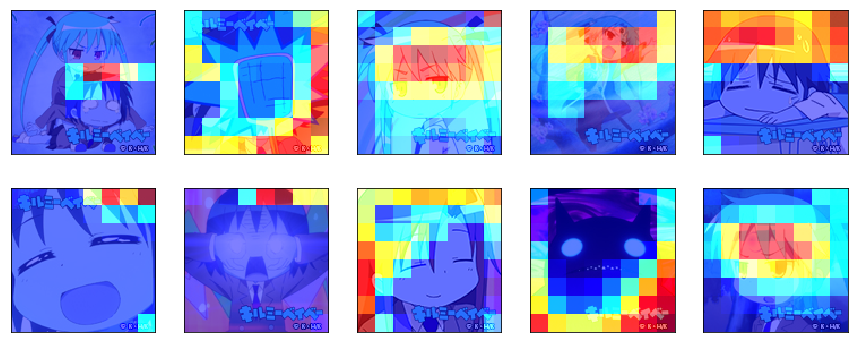

In [60]:
from keras import backend as K
plt.figure(figsize=(15, 6)) 
for i in range(10):
    gx=Grad_Cam(model, x_all[550+10*i], 'block5_conv3')
    plt.subplot(2,5,i+1),plt.imshow(gx),plt.xticks([]),plt.yticks([])
plt.show()

In [11]:
def make_middle_layer_model(model, layer_name=None):
    short_model = Model(input=model.input, output=model.get_layer(layer_name).output)
    return short_model

In [13]:
middle_layer_model = make_middle_layer_model(model, layer_name='dense_3')
#intermediate_layer_model = make_middle_layer_model(autoencoder, layer_name='max_pooling2d_15')
middle_layer_test = middle_layer_model.predict(x_all)
print(middle_layer_test.shape)

C:\Users\we_lo\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  


(686, 512)


In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state=42, perplexity=30.0)
X_tsne = tsne.fit_transform(middle_layer_test)

In [15]:
import matplotlib.pyplot as plt
from matplotlib import offsetbox
%matplotlib inline

8


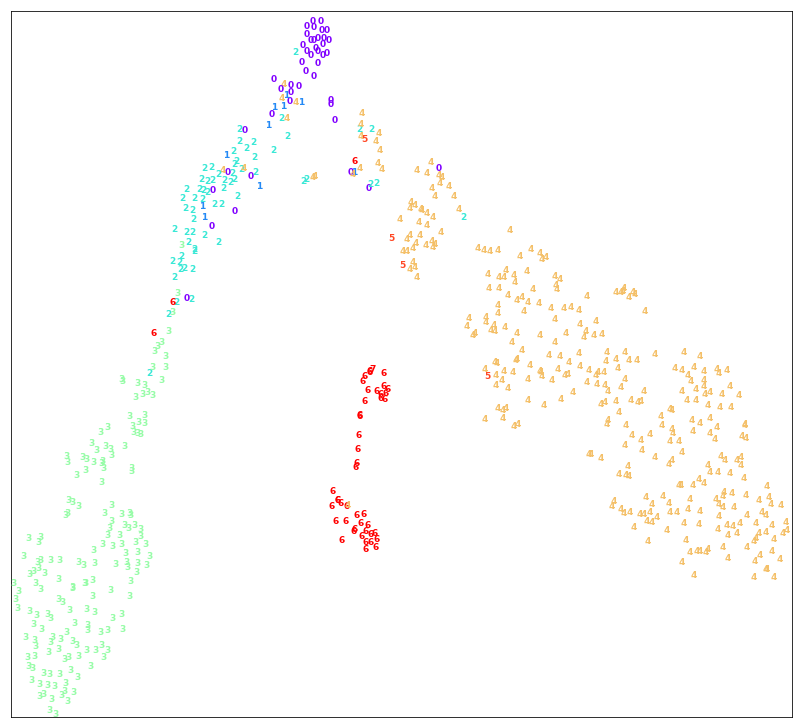

In [18]:
plt.figure(figsize=(14,13))
plt.xlim(X_tsne[:,0].min(), X_tsne[:,0].max()+1)
plt.ylim(X_tsne[:,1].min(), X_tsne[:,1].max()+1)
leny=len(set(y_all))
print(leny)
for i in range(len(x_all)):
    plt.text(X_tsne[i,0], X_tsne[i,1],str(y_all[i]),color=plt.cm.rainbow(y_all[i]/(5.5)), fontdict={'weight':'bold', 'size':9})
#plt.xlabel('tsne feature 0')
#plt.ylabel('tsne feature 1')
plt.xticks([]), plt.yticks([])
plt.savefig('image3-3.png', bbox_inches='tight')
plt.show()

In [44]:
def plot_embedding(X,X2,y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(14,13))
    ax = plt.subplot(111)
    leny=len(set(y))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.rainbow(y[i]/leny),fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        plt.gray()
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 1e-3 :#or y[i] in [0,1,2,3,4]:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X[i]]]
            #imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(X2[i].reshape(30,30),cmap=plt.cm.gray_r),X[i])
            pic=cv2.cvtColor(cv2.resize(X2[i], (32,32)), cv2.COLOR_BGR2RGB)
            imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(pic),X[i])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.savefig('image2-3.png', bbox_inches='tight')

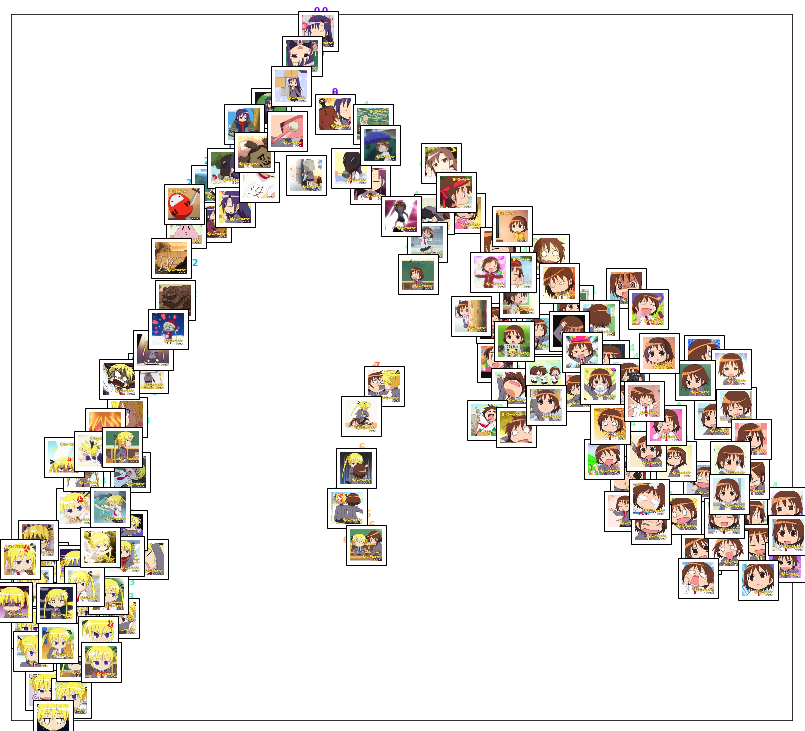

In [45]:
plot_embedding(X_tsne, x_all, y_all)

In [65]:
def plot_embedding2(X,X2,y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure(figsize=(14,13))
    ax = plt.subplot(111)
    leny=len(set(y))
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.rainbow(y[i]/leny),fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        plt.gray()
        for i in range(X.shape[0]):
            dist = np.sum((X[i] - shown_images) ** 2, 1)
            if np.min(dist) < 1e-3 :#or y[i] in [0,1,2,3,4]:
                # don't show points that are too close
                continue
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)
    plt.savefig('image2-3.png', bbox_inches='tight')

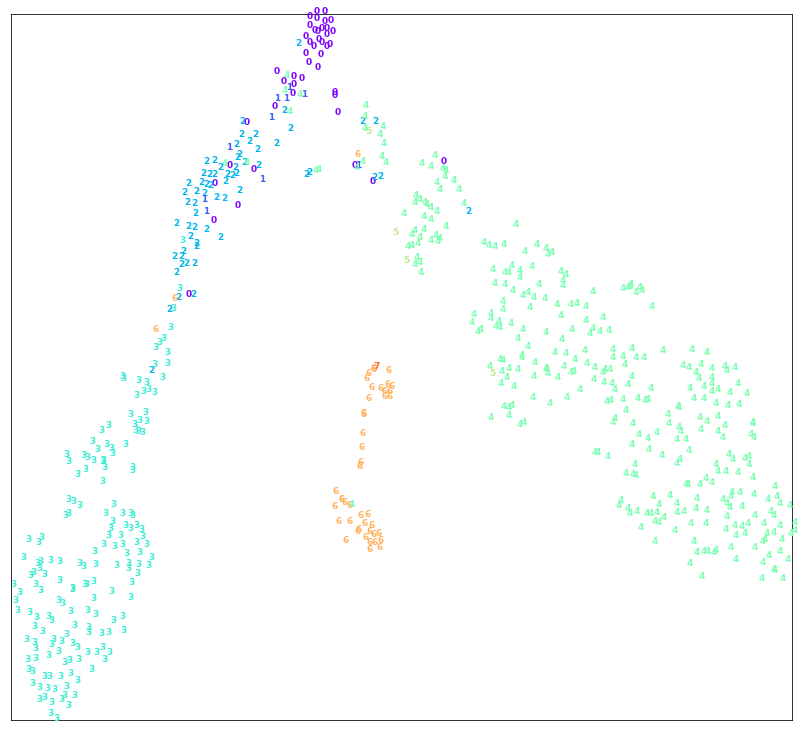

In [66]:
plot_embedding2(X_tsne, x_all, y_all)